In [20]:
from importlib import reload
from load_cluster_data import load_cluster_data
from pca_kmeans_init import pca_kmeans_init
from betabinomo_mix_singlecells import *
import betabinomo_mix_singlecells
reload(betabinomo_mix_singlecells)
import torch
import sklearn.manifold 
import plotnine as p9
import time

## Settings

In [2]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'

torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MAKE_PCA_TSNE = True

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 15 # should also be an argument that gets fed in

cuda


## Load data

In [ ]:
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])
N = coo_cluster_sparse.shape[0]
J = coo_cluster_sparse.shape[1]

cell_index_tensor, junc_index_tensor, my_data = betabinomo_mix_singlecells.make_torch_data(final_data, **float_type)

In [10]:
K = 15 # should also be an argument that gets fed in

cell_pcs, pc_sd, init_labels = pca_kmeans_init(final_data, junc_index_tensor, cell_index_tensor, K, float_type)


In [24]:
    
num_trials = 10 # should also be an argument that gets fed in
num_iters = 50 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
reload(betabinomo_mix_singlecells)
start_time = time.time()
results = [ betabinomo_mix_singlecells.calculate_CAVI(K, my_data, float_type, hypers, init_labels = None, num_iterations = num_iters) 
           for t in range(num_trials) ]
print(time.time() - start_time)

Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23766616.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23764992.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23766648.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23737678.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23767028.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23738384.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23749258.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23741334.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO converged @ -23743452.0  CAVI iteration #  50  complete
Initialize VI params
Got the initial ELBO ^
ELBO conver

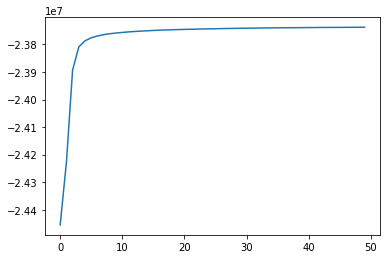

In [25]:

best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
    # run coordinate ascent VI
#ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(J, K, N, my_data, init_labels = None, num_iterations = num_iters)
elbos_all = np.array(elbos_all)
plt.plot(elbos_all[1:]); plt.show()
    

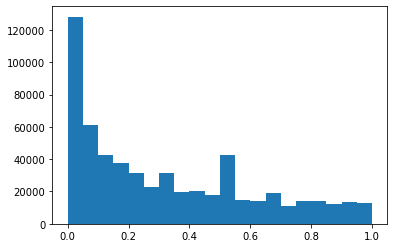

In [28]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)    
plt.hist(juncs_probs.cpu().numpy().flatten(), 20); plt.show()

In [29]:
theta_f_plot = pd.DataFrame(PHI_f.cpu().numpy())
theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
print(theta_f_plot_summ)

                   0             1         2         3         4         5  \
cell_id                                                                      
B           0.092715  1.670985e-02  0.160622  0.067583  0.021740  0.087911   
CD14Mono    0.108756  1.152848e-02  0.165727  0.074690  0.014173  0.082844   
CD8T        0.108022  8.154589e-03  0.181587  0.067941  0.015751  0.093684   
DC          0.105282  8.233580e-03  0.188199  0.058767  0.010975  0.065519   
FCGR3A      0.107413  1.190037e-02  0.154626  0.081110  0.023076  0.088654   
IGHA        0.098831  6.036226e-03  0.235888  0.058324  0.011788  0.065309   
MemoryCD4T  0.093309  1.442011e-02  0.166126  0.063541  0.020345  0.091406   
NK          0.099624  1.502037e-02  0.162388  0.067333  0.019872  0.090650   
NaiveCD4T   0.103668  1.136746e-02  0.172361  0.065655  0.015652  0.090095   
ZNF385D     0.018874  4.212681e-07  0.447074  0.028627  0.000003  0.065009   

                   6             7         8         9        1

How much each cluster is used

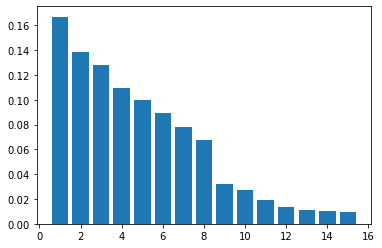

In [30]:
theta = GAMMA_f / GAMMA_f.sum()
theta = theta.cpu().numpy()
theta_sorted = np.sort(theta)
plt.bar(np.arange(K)+1,theta_sorted[::-1]); plt.show()


We're basically get hard assignmed :/ This means it doesn't make much sense to do an embedding/UMAP etc

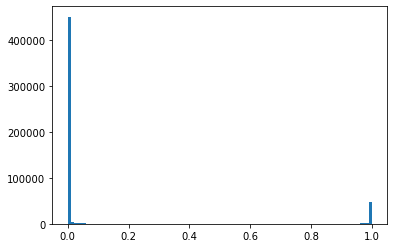

In [34]:
to_keep = theta > 0.04

x = PHI_f.cpu().numpy()
x = x[:,to_keep]
#x -= x.mean(1,keepdims=True)
#x /= x.std(1,keepdims=True)
_ = plt.hist(x.flatten(),100)

<Figure size 720x576 with 0 Axes>

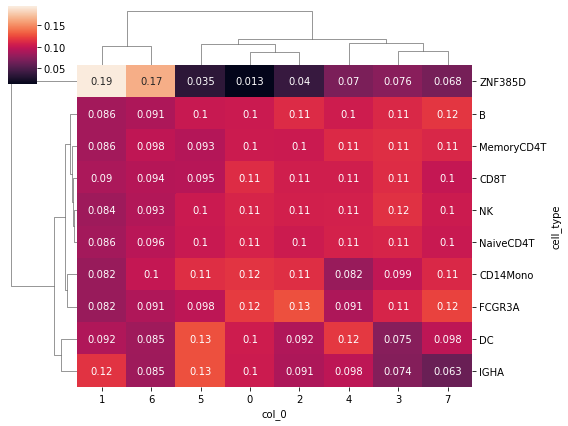

In [35]:
ct = pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )
ct_np = ct.to_numpy()

ct_np = ct_np / ct_np.sum(1, keepdims=True) # normalize cell-type counts
ct_np = ct_np / ct_np.sum(0, keepdims=True)

ct.iloc[:,:] = ct_np

ax = plt.figure(figsize=[10,8])
sns.clustermap(ct, dendrogram_ratio=0.15, vmin = None, figsize=(8,6), annot = True)
#plt.savefig("Cluster_heatmap.pdf")
